In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np

# Question 1 Exploratory Data Analysis

* From example/input/ load compustat.csv inside compustat.zip  without unzip compustat.zip
* 1. Variable names that we are interested in:
    * sic code: four digits integer for company
    * datecqtr: year/ quarter time for the record
    * cusip: compustats identifier for a company
    * chod: shares out of standing (in million)
    * saleq: sales of current quarter (in million)
    * prccq: close price of current quarter (in dollar)
    
* 2. For saleq and market cap, compute the following:
    * Time series mean 
    * Time Series standard deviation
    * Time Series count of missing values
    * Time Series ratio of missing values
    * Aggregate the result in a dataframe
        
* 3. Answer the following questions:
    * Before computing any value, what kinds of descriptive analysis would you do to check if there are outliers?
    * Implement some schemes to detect outliers.
    * Do you find some outliers? Could you think why? You can do some research using google.
    * What kinds of conclusion you can get from analyzing the table you get in 2? You can make some plots to illustrate.

In [2]:
import zipfile

In [3]:
## read compustat dataset
zf = zipfile.ZipFile("compustat.zip")
compustat = pd.read_csv(zf.open("compustat.csv"), header = 0)

In [4]:
compustat.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,cusip,curcdq,datacqtr,datafqtr,cshoq,saleq,costat,prccq,sic
0,1000,19660331,1966,1,INDL,C,D,STD,000032102,USD,1966Q1,1966Q1,0.219,NaN,I,NaN,3089.0
1,1000,19660630,1966,2,INDL,C,D,STD,000032102,USD,1966Q2,1966Q2,0.219,NaN,I,NaN,3089.0
2,1000,19660930,1966,3,INDL,C,D,STD,000032102,USD,1966Q3,1966Q3,0.219,NaN,I,NaN,3089.0
3,1000,19661231,1966,4,INDL,C,D,STD,000032102,USD,1966Q4,1966Q4,0.219,4.032,I,NaN,3089.0
4,1000,19670331,1967,1,INDL,C,D,STD,000032102,USD,1967Q1,1967Q1,0.277,NaN,I,NaN,3089.0


In [5]:
#get useful variables
data = pd.DataFrame(compustat, columns=['sic', 'datacqtr', 'cusip', 'cshoq', 'saleq', 'prccq'])
data.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq
0,3089.0,1966Q1,000032102,0.219,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN


In [6]:
#add a new column
data.loc[:, "mkt_cap"] = data.loc[:, "prccq"] * data.loc[:, "cshoq"]
data.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq,mkt_cap
0,3089.0,1966Q1,000032102,0.219,NaN,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN,NaN


In [7]:
#calculate Time series mean, sd, count of missing values, ratio of missing values
def calculator(x):
    num = x.isnull().sum()
    return pd.Series([x.mean(), x.std(), num, num/ (num + x.count())], index=['mean', 's.d.', 'count of missing values', 'ratio of missing values'])

In [8]:
#calculate those values for saleq and market cap
result = pd.DataFrame(data, columns=['saleq', 'mkt_cap']).apply(calculator)
result

,saleq,mkt_cap
mean,445.150664,2057.473104
s.d.,2679.706576,13202.197457
count of missing values,269498.000000,468276.000000
ratio of missing values,0.148787,0.258530


Before computing any value, what kinds of descriptive analysis would you do to check if there are outliers?

* 3-sigma rule of normal distribution
* We can draw boxplots to detect outliers.

In [9]:
import matplotlib.pyplot as plt

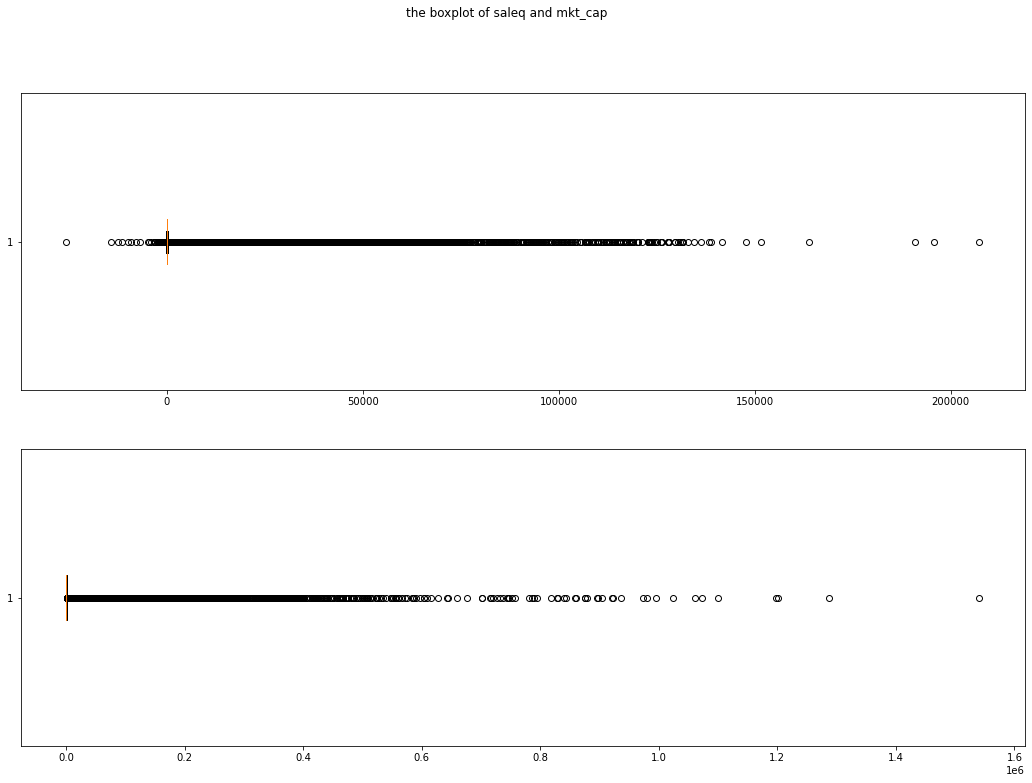

In [13]:
fig, ax_lst = plt.subplots(2, 1, figsize=(18,12))
fig.suptitle('the boxplot of saleq and mkt_cap') 
ax_lst[0].boxplot(data['saleq'].dropna(), vert=False)
ax_lst[1].boxplot(data['mkt_cap'].dropna(), vert=False)
plt.show()

Do you find some outliers? Could you think why? You can do some research using google.

* It is easy to see that there are some outliers with respect to the variable 'saleq'.
* But the long right tail distribution is reasonable for the market because the data includes different sizes of companies and there were some huge events happened every year to affect economy.

# Question 2 Compute Industry Concentration

The defination of HHI index could be found: 

https://www.investopedia.com/terms/h/hhi.asp#:~:text=The%20Herfindahl%2DHirschman%20Index%20(HHI)%20is%20a%20commonly%20accepted,close%20to%20zero%20to%2010%2C000.

This index is used to measure the industry concentration and was used by congressman to determine whether to approve a merge deal or not.

Using the same data in question 1. Compute a panel data for HHI index for all industry, using a 2 digit SIC code.

Choose top 4 industry with the highest average HHI index, plot their time series pattern of HHI in a 2 by 2 figure.

In [43]:
dataHHI = pd.DataFrame(data, columns=['datacqtr', 'sic', 'mkt_cap'])
dataHHI = dataHHI.dropna()
dataHHI = dataHHI.groupby(['sic','datacqtr'],as_index=False).sum() 
dataHHI['sic_code'] = dataHHI['sic']//100 

# calculate the sum of mkt_cap
sum_cap = dataHHI.groupby(['datacqtr','sic_code'])['mkt_cap'].sum().reset_index()
sum_cap.rename(columns={'mkt_cap':'sum_cap'},inplace=True)

dataHHI = pd.merge(dataHHI, sum_cap, on=['datacqtr', 'sic_code'])
dataHHI.head()

,sic,datacqtr,mkt_cap,sic_code,sum_cap
0,100.0,1967Q4,65.205000,1.0,65.205000
1,100.0,1968Q1,62.617500,1.0,62.617500
2,100.0,1968Q2,109.295875,1.0,109.295875
3,100.0,1968Q3,119.726905,1.0,119.726905
4,100.0,1968Q4,211.665500,1.0,211.665500


In [44]:
#calculate the HHI 
dataHHI['mkt_perct'] = dataHHI['mkt_cap'] / dataHHI['sum_cap']
dataHHI['hhi'] = pow(dataHHI['mkt_perct'] * 100, 2)
groupbyHHI = dataHHI.groupby(['datacqtr','sic_code'])['hhi'].sum().reset_index()
groupbyHHI.rename(columns={'hhi':'HHI_index'},inplace=True)

dataHHI = pd.merge(dataHHI, groupbyHHI, on=['datacqtr', 'sic_code'])
dataHHI.head()

,sic,datacqtr,mkt_cap,sic_code,sum_cap,mkt_perct,hhi,HHI_index
0,100.0,1967Q4,65.205000,1.0,65.205000,1.0,10000.0,10000.0
1,100.0,1968Q1,62.617500,1.0,62.617500,1.0,10000.0,10000.0
2,100.0,1968Q2,109.295875,1.0,109.295875,1.0,10000.0,10000.0
3,100.0,1968Q3,119.726905,1.0,119.726905,1.0,10000.0,10000.0
4,100.0,1968Q4,211.665500,1.0,211.665500,1.0,10000.0,10000.0


In [46]:
HHI_mean = dataHHI.groupby(['sic_code'])['HHI_index'].mean().reset_index()
HHI_mean = HHI_mean[HHI_mean['HHI_index'] < 10000]
HHI_mean.sort_values(by='HHI_index', ascending=False, inplace=True)
HHI_mean.head()

,sic_code,HHI_index
49,58.0,9934.800747
32,40.0,9923.524283
58,70.0,9902.525227
21,29.0,9660.884951
13,21.0,8977.683518


In [50]:
#top 4
HHI_sic = [HHI_mean.iloc[i, 0] for i in range(4)]
HHI_sic

[58.0, 40.0, 70.0, 29.0]

In [74]:
#data for top 4 industry with the highest average HHI index
HHI_top4 = pd.DataFrame(dataHHI, columns=['datacqtr', 'sic_code', 'HHI_index'])
HHI_top4 = HHI_top4[HHI_top4['sic_code'].isin(HHI_sic)]
HHI_top4.drop_duplicates(inplace=True)
HHI_top4.reset_index(drop=True, inplace=True)
HHI_top4['datacqtr'] = pd.to_datetime(HHI_top4['datacqtr'].str[:4] + HHI_top4['datacqtr'].str[4:6])
HHI_top4.head()

,datacqtr,sic_code,HHI_index
0,1966-01-01,29.0,10000.000000
1,1966-04-01,29.0,10000.000000
2,1966-07-01,29.0,10000.000000
3,1966-10-01,29.0,10000.000000
4,1967-01-01,29.0,5426.014686


In [75]:
time_data = HHI_top4.pivot(index='datacqtr', columns='sic_code', values='HHI_index')
time_data.dropna(inplace=True)
time_data

sic_code,29.0,40.0,58.0,70.0
datacqtr,,,,
1967-10-01,5012.337056,9586.473875,10000.000000,10000.0
1968-01-01,6542.375959,10000.000000,10000.000000,10000.0
1968-04-01,5441.119064,10000.000000,10000.000000,10000.0
1968-10-01,6671.482327,9799.633620,10000.000000,10000.0
1969-04-01,7026.116164,9285.417305,10000.000000,10000.0
...,...,...,...,...
2019-01-01,9857.598674,10000.000000,9819.565617,10000.0
2019-04-01,9846.427122,10000.000000,9930.307862,10000.0
2019-07-01,9825.724584,10000.000000,9853.862059,10000.0


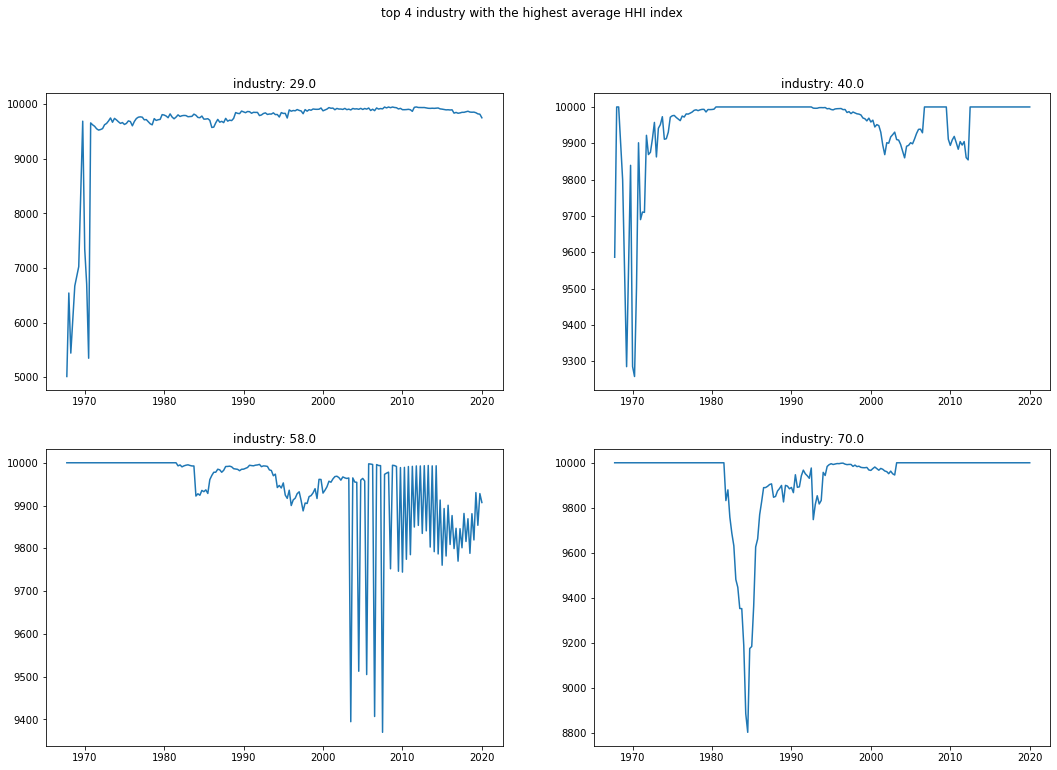

In [76]:
# plot their time series pattern of HHI
fig, ax_lst = plt.subplots(2, 2, figsize=(18,12))
fig.suptitle('top 4 industry with the highest average HHI index') 

ax_lst[0, 0].plot(time_data.index, time_data.iloc[:, 0])
ax_lst[0, 0].set_title('industry: ' + str(time_data.columns[0]))
# ax_lst[0, 0].axes.get_xaxis().set_visible(False)

ax_lst[0, 1].plot(time_data.index, time_data.iloc[:, 1])
ax_lst[0, 1].set_title('industry: ' + str(time_data.columns[1]))

ax_lst[1, 0].plot(time_data.index, time_data.iloc[:, 2])
ax_lst[1, 0].set_title('industry: ' + str(time_data.columns[2]))

ax_lst[1, 1].plot(time_data.index, time_data.iloc[:, 3])
ax_lst[1, 1].set_title('industry: ' + str(time_data.columns[3]))

plt.show()